# Randomized Optimization Algorithms

## Introduction

In the previous assighnment we analysed various supervised algorithms, which were all solving some optimization problem in the form of minimizing the derivative of the error. What if the derivative does not exists, like in discrete problems which are not defined on continuous functions? Since discrete functions cannot be differentiated, then gradient descent tool cannot be used.
Here we turn towards search and various way of optimizing it using randomized optimization algorithms. 

## Finding weights for ANN

In this section I will use optimization algorithms to search for the best weights in the Neural Network classification on the problem of Higgs detection from the previous assignment.

Quick review:

   - given outcomes of particle decays, detect Higgs boson; 
   
   - most of the supervised algorithms gave acceptable accuracy ranging from 0.8 - 0.9;
   
   - neural network gave the worse accuracy of around 0.5 (50%) across all expreriments with tunning paramaters;
    
Since backpropagation algorithm in the neural network did not provide satisfactory accuracy on the higgs dataset, the problem is higgs detection becomes a great candidate to apply randomized optimization algorithms weights learning.

From the previous assignment it was concluded that dataset size of 20k records will suffice the experiment while saving running time significantly:

In [1]:
%matplotlib inline

In [2]:
from algo_evaluation.datasets import *

In [4]:
higgs_data = load_higgs_train(sample_size=20000)
features, weights, labels = higgs_data
print 'Size of the dataset:', features.shape[0]
print 'Number of features:', features.shape[1]
print 'Number of positives (signal):', labels.value_counts()['s']
print 'Number of negatives (background):', labels.value_counts()['b']

Size of the dataset: 5477
Number of features: 13
Number of positives (signal): 2525
Number of negatives (background): 2952


In [9]:
from algo_evaluation.supervised import neural_network as nn
reload(nn)

<module 'algo_evaluation.supervised.neural_network' from '/Users/sshegheva/workspace/bag-of-algorithms/algo_evaluation/supervised/neural_network.py'>

Learning weights for the neural network will be achieved using pybrain library (same as in the previous assignment). 

The __cost function__ here (called evaluator) will be __MSE__ (maximum squared error) and the goal is to minimize it using three different optimization algorithms: HillClimber, Genetic Algorithm and Simulated Anealing.

__Fitness function__ would required maximization of __-MSE__

Overall, comparing to Backpropagation algorithm, learning weights by means of randomized optimization algorithms performed slightly beter and significantly faster.

In [10]:
df_nn = nn.compare_weight_learning_optimized(higgs_data)

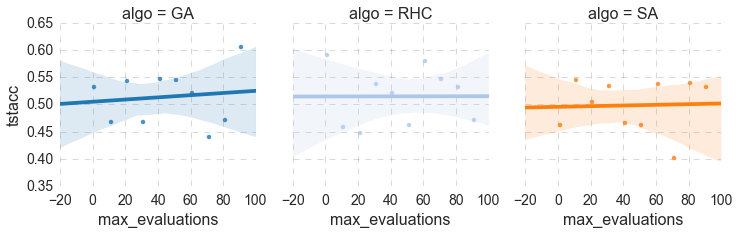

In [11]:
nn.plot_weight_learning_accuracy(df_nn)

__Accuracy__: On the left side, learning accuracy curve is presented as a function of max_evaluations and since there is a lot of volatility, I also presented the KDE plot of the accuracy scores.

KDE plot showed that _simulated annealing_ and _genetic algorithm_ on average performed better that _hill climber_.

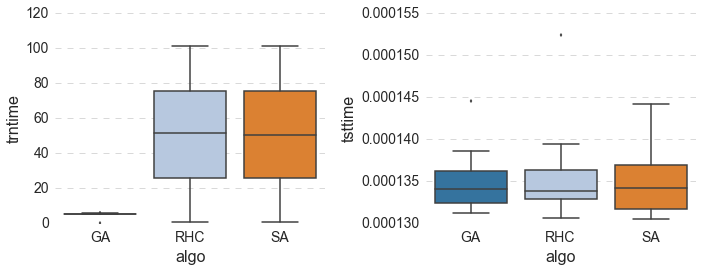

In [8]:
nn.plot_weight_learning_time(df_nn)

__Running Time__:
Evaluation three randomized algorithms for learning optimal weights did not give much variability for running time. All algorithms are comparable and time grows linearly as number of evaluations increases.
I also showed the prediction times which are averaged across dataset size - again comparable results.
    

#### Optimization Problem #1: Drawing Mona Lisa with Travelling Salesman Problem

In February 2009, Robert Bosch created a 100,000-city instance of the traveling salesman problem (TSP) that provides a representation of Leonardo da Vinci's Mona Lisa as a continuous-line drawing. 
I decided that this would be a perfect problem to try out the optimization algorithms, both, from aestetic reasons, as well as scale challenge.

I used hexagon binning on the whole dataset to visualize the structure, however for the purpose of algorithms evaluation, I sampled 10% of data points to avoid memory issues (as I have observed through initial experimentation)

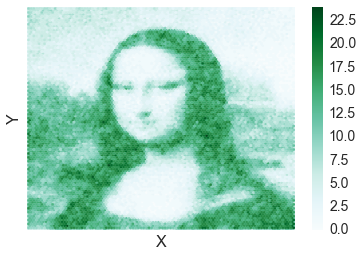

In [14]:
from algo_evaluation.datasets import *
df_mn = load_mona_lisa(sample_size=100000, display=True)

#### Optimization Problem #2: Searching for Waldo with "Where is Waldo?" book series

I only recently came across Waldo-spotting book series (since I grew up outside of US) through the blogpost of Randy Olson where he demonstrated optimal search using genetic algorithm. This problem fascinated me by being both fun and illuminating and here I tried to reproduce some of his results using different randomized optimization algorithms

In [1]:
%matplotlib inline
from algo_evaluation import datasets
waldo_df = datasets.load_waldo_dataset(display=False)

#### Fitness function

In [2]:
from algo_evaluation.optimization.problems import waldo_optimization as wo
reload(wo)

<module 'algo_evaluation.optimization.problems.waldo_optimization' from '/Users/sshegheva/workspace/bag-of-algorithms/algo_evaluation/optimization/problems/waldo_optimization.pyc'>

In [3]:
rhc_df, sa_df, ga_df = wo.compare_all(waldo_df)

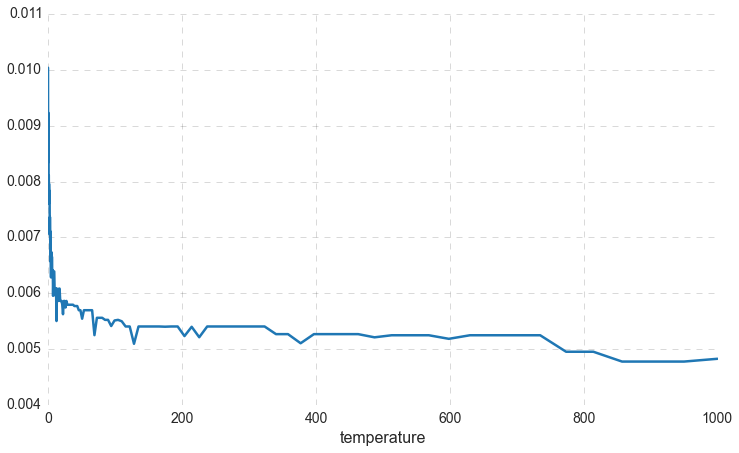

In [9]:
sa_df.set_index('temperature').optimal_value.plot()

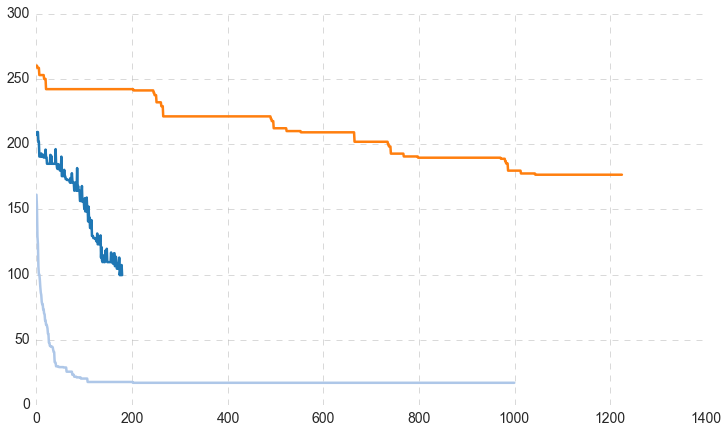

In [12]:
sa_df.cost.plot()
ga_df.cost.plot()
rhc_df.cost.plot()

In [114]:
df_w = ga.evaluate_ga(wop)

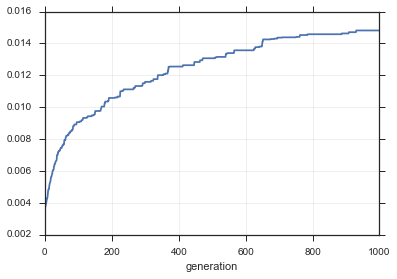

In [115]:
df_w.set_index('generation')['optimal_value'].plot()

In [124]:
df_w

,generation,cost,path,optimal_value
0,0,280.311716,"(B3P9, B5P8, B5P1, B2P2, B6P1, B2P5, B6P11, B5...",0.003567
1,1,275.211394,"(B3P9, B5P8, B5P1, B2P2, B6P1, B2P5, B6P11, B5...",0.003634
2,2,268.410969,"(B3P9, B5P8, B1P6, B3P2, B6P12, B4P8, B3P11, B...",0.003726
3,3,262.249134,"(B3P9, B5P8, B1P6, B3P2, B6P12, B4P8, B3P11, B...",0.003813
4,4,256.009678,"(B3P9, B5P8, B1P6, B3P2, B6P12, B4P8, B3P11, B...",0.003906
5,5,250.531359,"(B3P9, B5P8, B4P4, B4P2, B1P12, B7P3, B1P2, B5...",0.003992
6,6,240.214772,"(B3P9, B5P8, B1P6, B3P2, B6P12, B4P8, B3P11, B...",0.004163
7,7,233.568655,"(B3P9, B5P8, B1P6, B3P2, B6P12, B4P8, B3P11, B...",0.004281
8,8,233.568655,"(B3P9, B5P8, B1P6, B3P2, B6P12, B4P8, B3P11, B...",0.004281
9,9,226.840065,"(B3P9, B5P7, B5P1, B2P2, B4P7, B2P5, B6P11, B5...",0.004408


We need to minimaize the distance between what waldo-looking solutions covers and the real waldo coordinates. 

Genetic algorithm continuosly tinkers with the solution by slightly mutating the existing best solution until no better solution can be found.

#### Optimization Problem #3: Automatic Algorithm Configuration

Finding the best fitting classifier for datasets remains an art to be mastered with years of experience. I recently read the paper from the 13th PYTHON IN SCIENCE CONF. (SCIPY 2014) and was thrilled to learn about an ongoing effort developing hyperopt library, which treats the choice of the classifier and pre-processing modules as an optimization problem.  

### References

[1] Pybrain Optimization Documentation, Online Available, at http://pybrain.org/docs/tutorial/optimization.html

[2] http://www.cc.gatech.edu/~isbell/papers/isbell-mimic-nips-1997.pdf

[3] http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.optimize.anneal.html

[4] http://www.randalolson.com/2015/02/03/heres-waldo-computing-the-optimal-search-strategy-for-finding-waldo/

[5] http://www.math.uwaterloo.ca/tsp/data/ml/monalisa.html

[6] Hyperopt-Sklearn: Automatic Hyperparameter Configuration for Scikit-Learn http://conference.scipy.org/proceedings/scipy2014/pdfs/komer.pdf